#  Analysis through 201707

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import pandas as pd
import mscl_utils as mscl
import seaborn as sns
import tqdm
colors = mscl.set_plotting_style()
%matplotlib inline

## Loading in the data.  

In [8]:
data = pd.read_csv('data/201707_processed_markers.csv')
data = data[data['sd'] != '10sd1']
max_exp = np.max(data['exposure_ms'].unique())
cal_data = pd.read_csv('data/201707_intensity_calibration_data.csv')
cal_data['rescaled_intensity'] = cal_data['sub_intensity'] * max_exp / cal_data['exposure_ms']
cells = cal_data[(cal_data['sd']=='MLG910_pad')]
# Rescale the sd1 data. 
sd1_factor = np.median(data[data['sd'] == 'sd1']['rescaled_int'])/\
        np.median(cal_data[cal_data['sd']=='sd1']['rescaled_intensity'])
    
data.loc[data['sd']=='sd1', 'rescaled_int'] /= sd1_factor

# Compute fluorescence per channel. 
NUM_CHANNEL = 340
fl_per_channel = np.mean(cells['rescaled_intensity'] *\
                        cells['area']) / NUM_CHANNEL
std_per_channel = np.std(cells['rescaled_intensity'] *\
                        cells['area']) / (NUM_CHANNEL * np.sqrt(len(cells)))
cal_data['channel_density'] = cal_data['rescaled_intensity'] / fl_per_channel
data['channel_density'] = data['rescaled_int'] / fl_per_channel
save_data = data.drop(['date', 'exposure_ms', 'mean_bg', 'raw_rescaled', 'fluo_name', 'phase_name', 'x_pos', 'y_pos', 'mask_label',
                   'label_cent_x', 'label_cent_y', 'dist', 'rescaled_int', 'sub_int'],
                 axis=1)
save_data.to_csv('data/201707_survival_data.csv', index=False)

In [9]:
save_data.head()

,sd,flow_rate,survival,intensity,area,channel_density
0,16sd0,0.02,False,264033.297937,7.9104,19.458879
1,16sd0,0.02,False,284751.041667,1.9200,23.907528
2,16sd0,0.02,False,316555.543664,3.7376,30.736799
3,16sd0,0.02,False,323009.197695,3.6096,32.122569
4,16sd0,0.02,False,264033.297937,7.9104,19.458879


In [82]:
print(fl_per_channel, std_per_channel)

4657.086315954964 100.056467023


(array([  1.,   0.,   2.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,   4.,
          0.,   1.,   5.,   5.,   5.,   5.,   6.,  12.,  13.,  14.,  20.,
         15.,  16.,  18.,   9.,  11.,  14.,  11.,  13.,  20.,   9.,  14.,
          6.,   8.,   7.,   9.,   8.,   3.,   9.,   9.,   7.,   4.,   3.,
          4.,   4.,   1.,   3.,   7.,   3.,   1.,   4.,   5.,   3.,   3.,
          4.,   1.,   4.,   1.,   1.,   2.,   2.,   4.,   0.,   1.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  2.5088    ,   2.67810133,   2.84740267,   3.016704  ,
          3.18600533,   3.35530667,   3.524608  ,   3.69390933,
          3.86321067,   4.032512  ,   4.20181333,   4.37111467,
          4.540416  ,   4.70971733,   4.87901867,   5.04832   ,
          5.21762133,   5.38692267,   5.556224  ,   5.72552533,
          5.89482667,   6.064128  ,   6.23342933,   6.40273067,
          6.572032  ,   6.74133333,   6.91063467,   7.079936  ,
          7.24923733,   7.41853867,   7.5878

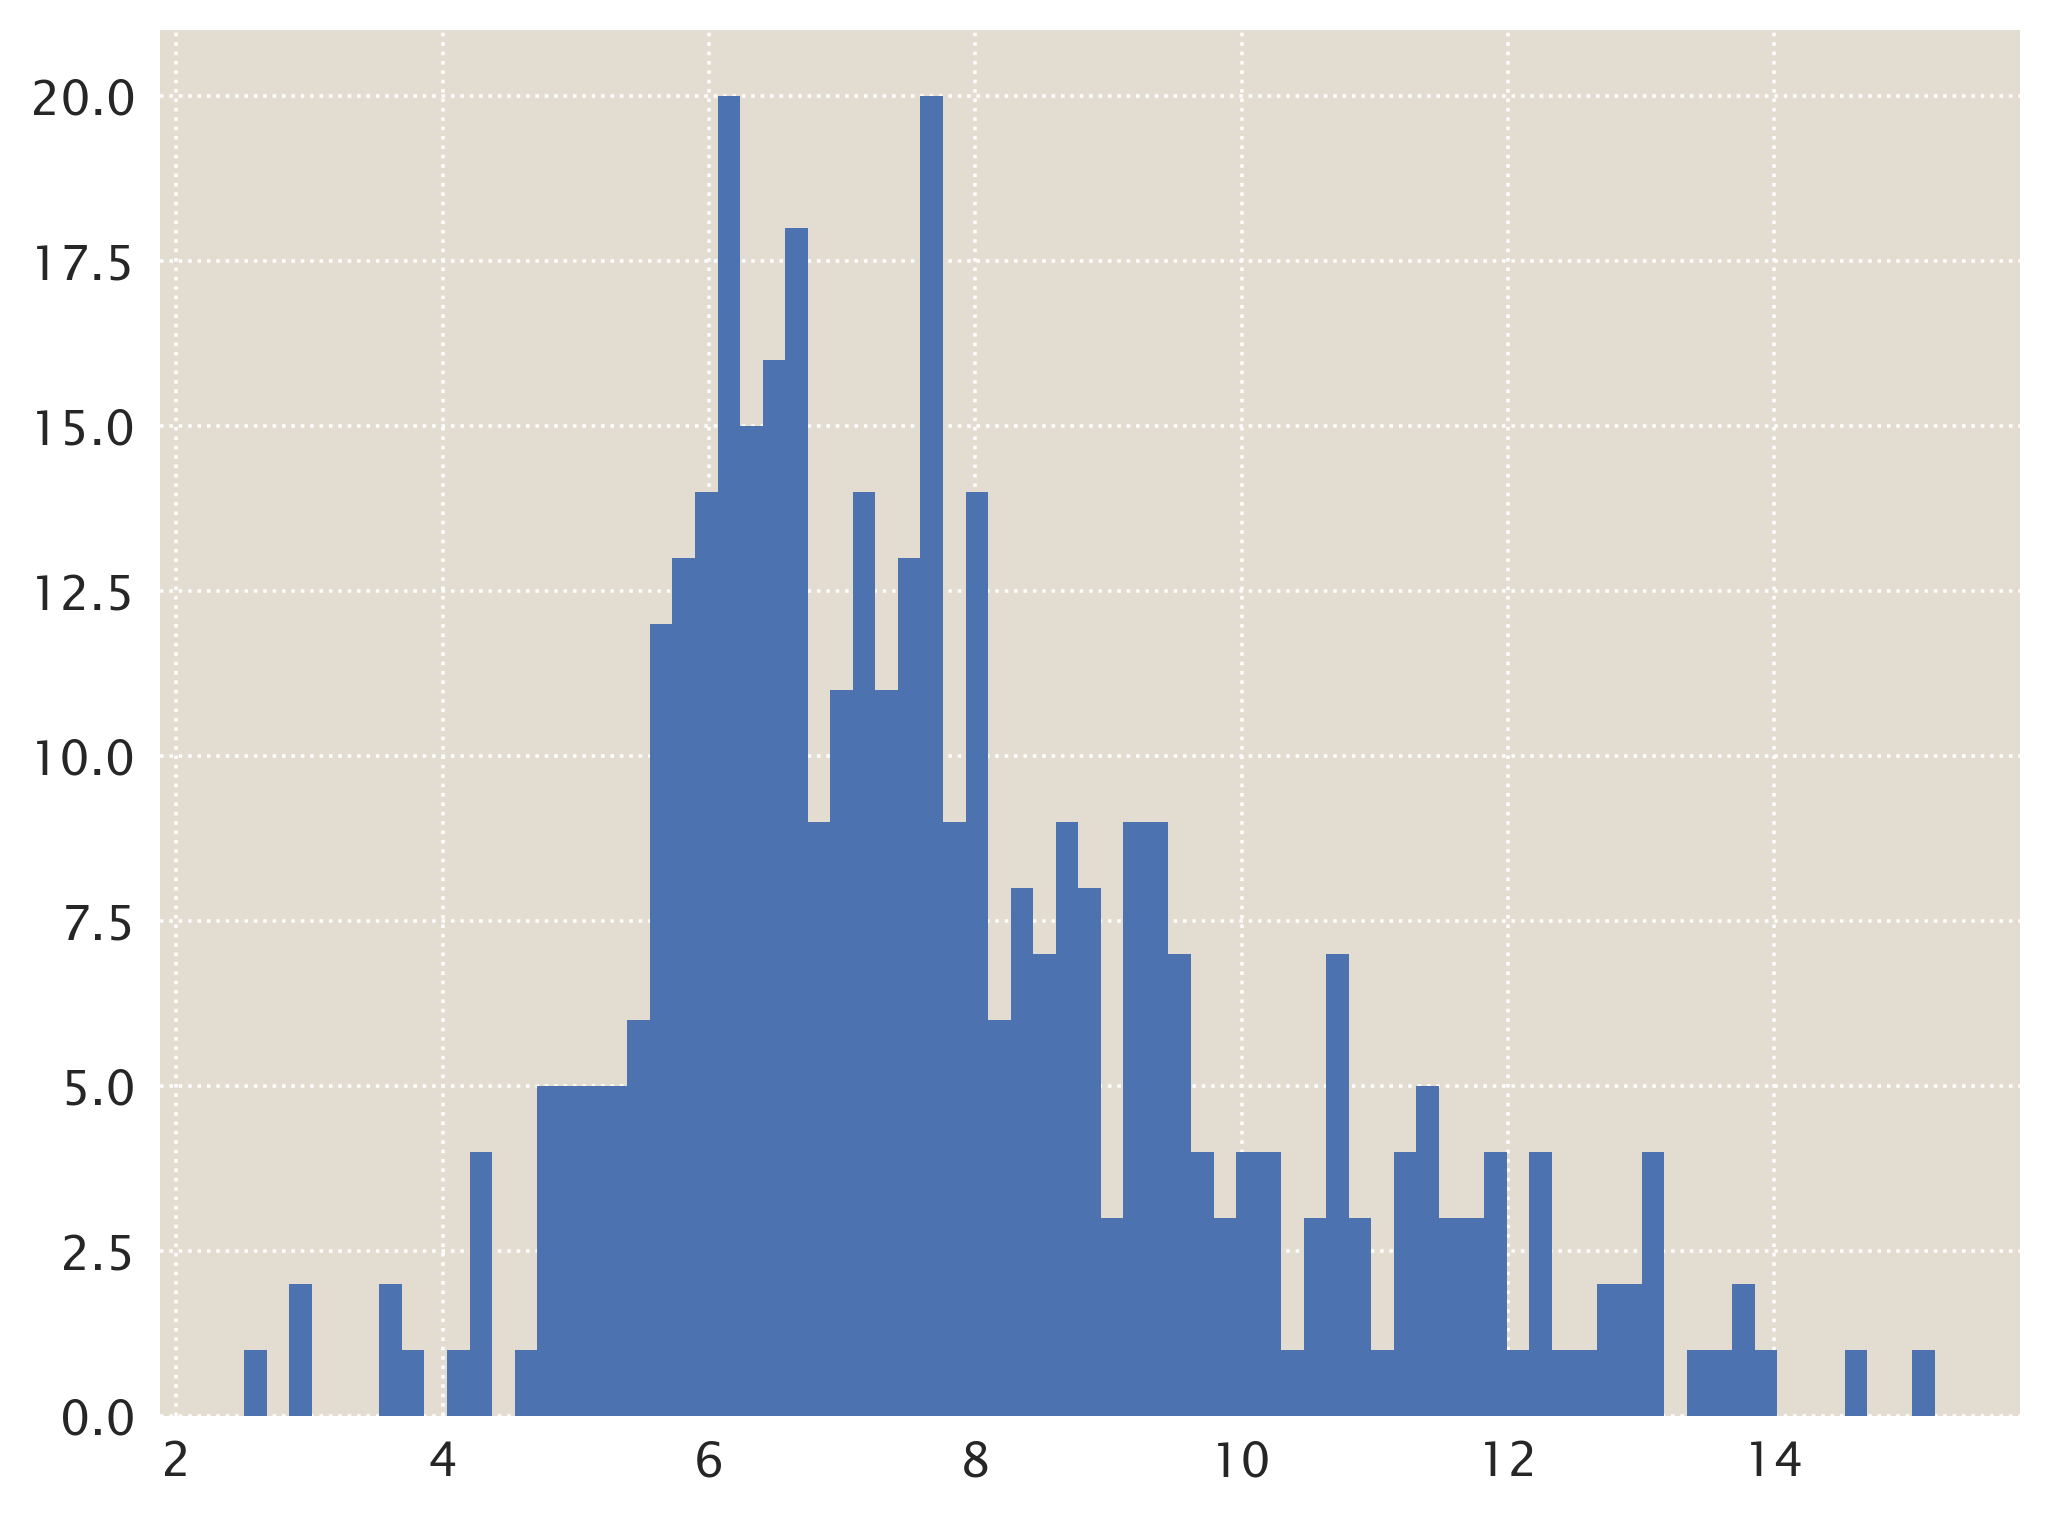

In [30]:
plt.hist(cal_data[cal_data['sd']=='MLG910_pad']['area'], bins=75)

(0, 1500000)

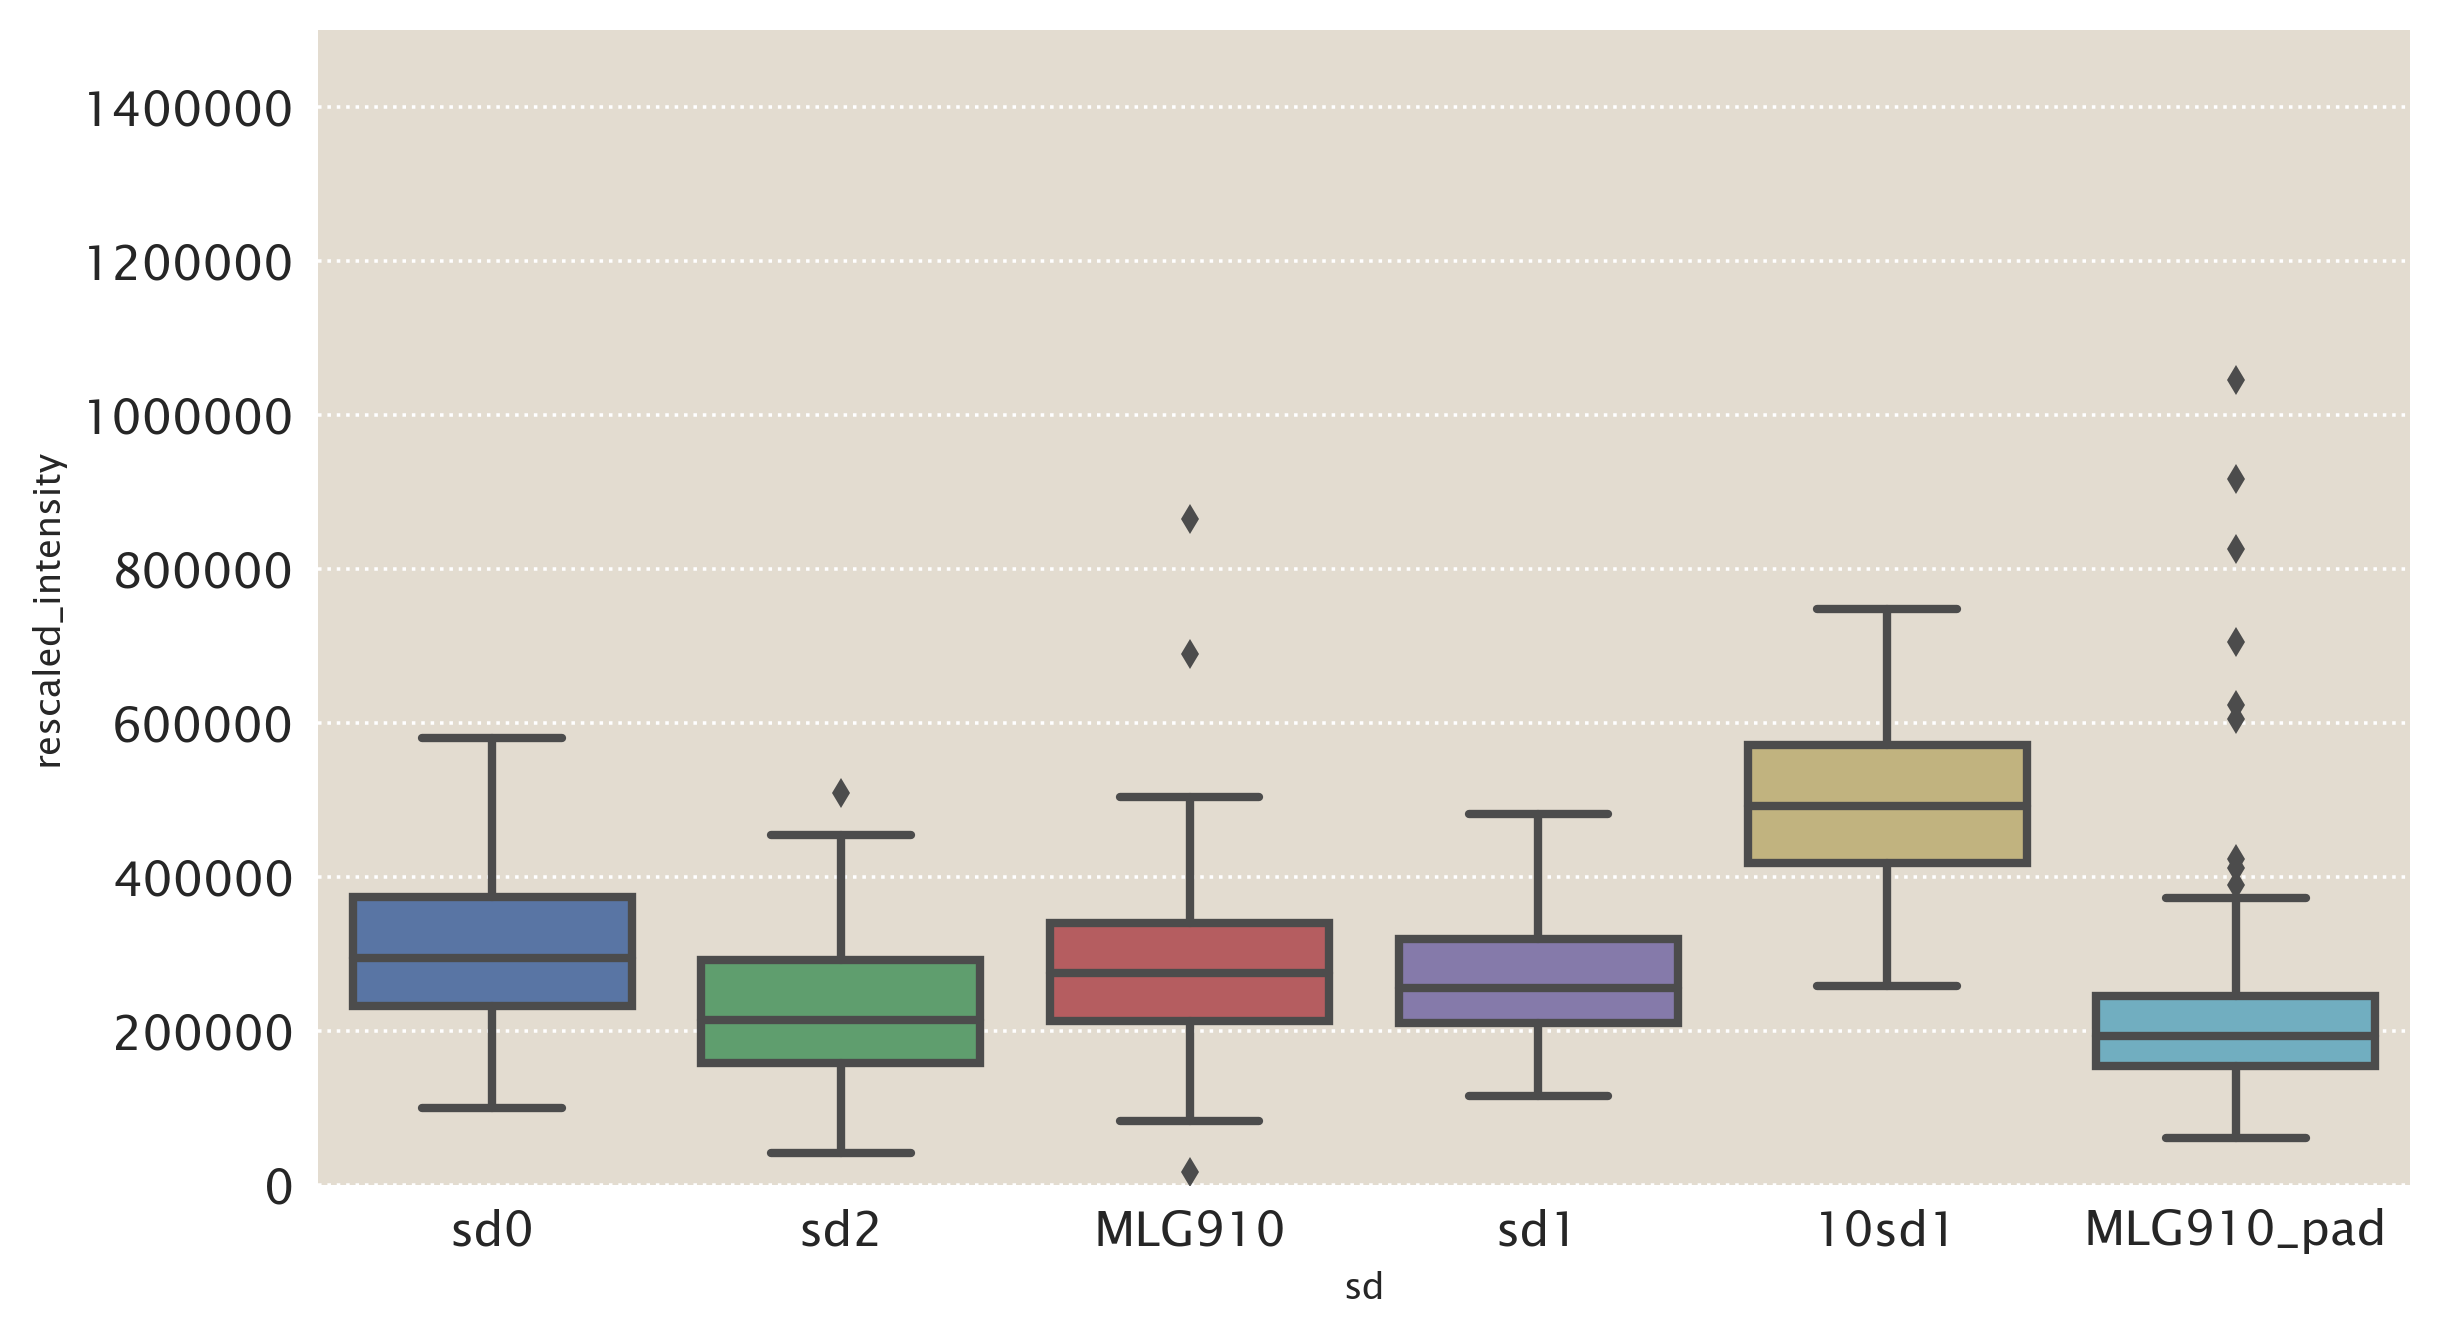

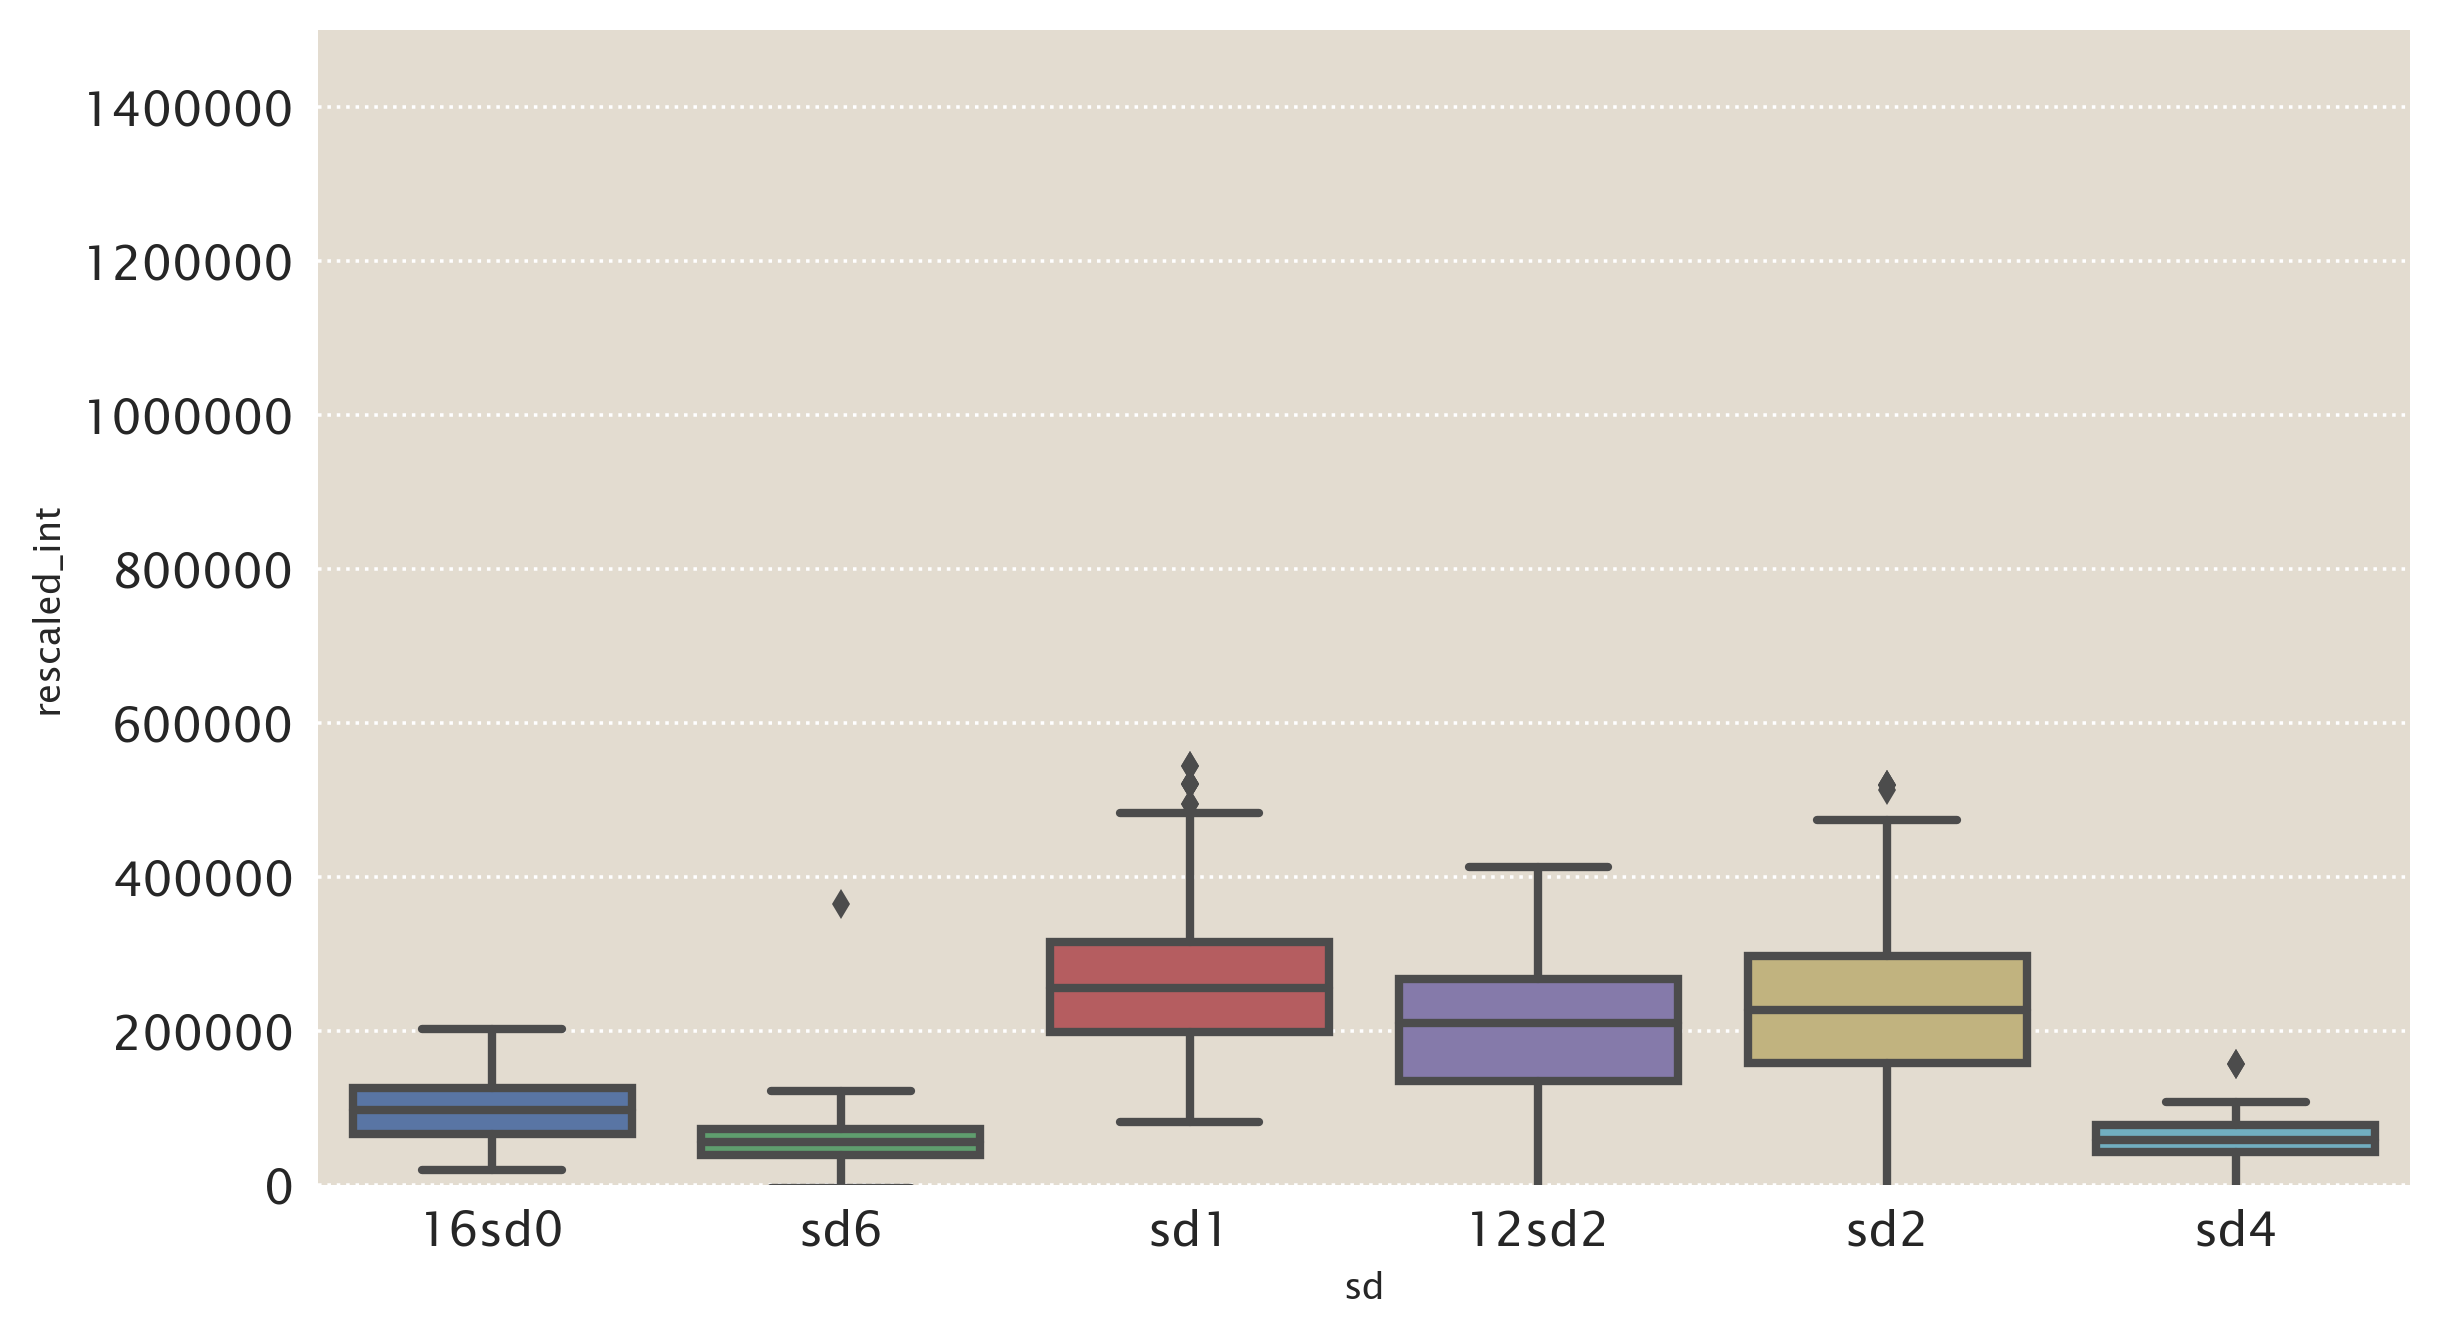

In [16]:
fig, ax = plt.subplots(1,1, True, figsize=(9,5), sharey=True)
sns.boxplot(x='sd', y='rescaled_intensity', data=cal_data, ax=ax)
ax.set_ylim((0, 1500000))
fig, ax = plt.subplots(1,1, True, figsize=(9,5), sharey=True)
sns.boxplot(x='sd', y='rescaled_int', data=data, ax=ax)
ax.set_ylim((0, 1500000))
# sns.boxplot(x='sd', y='rescaled_int', data=data, ax=ax[1])

In [17]:
cal_data.sd.unique()

array(['sd0', 'sd2', 'MLG910', 'sd1', '10sd1', 'MLG910_pad'], dtype=object)

In [54]:
# make a copy of the dataframe to manipulate.
df = data.copy()
# df = df[(df['sd'] != 'sd1') & (df['sd'] != '10sd1')]
# Remove unnecessary columns.
df.drop(['fluo_name', 'phase_name', 'x_pos', 'y_pos', 'mask_label',
                   'label_cent_x', 'label_cent_y', 'dist'],
                 axis=1, inplace=True)
# Group flow rates into 'slow' and 'fast'
_groups = df['flow_rate'] < 1.0 
groups = ['slow' if x == True else 'fast' for x in _groups]
df.insert(np.shape(df)[1], 'flow_group', groups)

# Perform the binning by consolidating the number of cells. 
channel_bin = 15 
bins = np.arange(0, data['channel_density'].max(), channel_bin)

# df.insert(np.shape(df)[1], 'fluo_bin', 0)
for i in tqdm.tqdm_notebook(range(0, len(bins) - 1)): 
    df.loc[(df['channel_density'] >= bins[i]) &\
       (df['channel_density'] < bins[i+1]), 'bin_no'] = int(i)
    
# Group by the flow rate and bin_no
grouped = df.groupby(['flow_group', 'bin_no'])
g_dict = {'slow': 0, 'fast': 1}
rev_dict = {0:'slow', 1:'fast'}
events = [{}, {}]
for g, d in grouped:
    events[g_dict[g[0]]][g[1]]= len(d)
    
min_cells = 50 
changed_keys = [{}, {}]
for i, flow in enumerate(events):
    low_keys = []
    for k in flow.keys():
        if flow[k] < min_cells:
            low_keys.append(k)
            
    # Separate them sequentially
    split_keys = []
    inds = np.where(np.diff(low_keys) > 1)[0]
    if len(inds) > 0:
        for j in range(len(inds)):
            if j==0:
                split_keys.append(low_keys[: inds[j] + 1])
            elif i==(len(inds) - 1):
                split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
                split_keys.append(low_keys[inds[j]+1: ])
            else:
                split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
    else:
        split_keys = [low_keys]
    for rng in split_keys:
        n_cells = np.sum(flow[z] for z in rng)
        if np.sum(flow[z] for z in rng) >= min_cells: 
            for z in rng:
                changed_keys[i][z] = np.min(rng)

        else:
            for z in rng:
                changed_keys[i][z] = np.min(rng) - 1

    # Change the bin number in the DataFrame. 
    for k in changed_keys[i].keys():
        df.loc[(df['flow_group'] == rev_dict[i]) & (df['bin_no']== k),\
               'bin_no'] = changed_keys[i][k]

In [55]:
grouped = df.groupby('flow_group')
colors = sns.color_palette('deep')
columns = ['flow_group', 'bin_number', 'mean_intensity', 'channel_density', 'min_int', 'max_int',
            'survival_probability', 'survivor_error']
dfs = []
for g, d in grouped: 
    # Group the data by the bin number. 
    _grouped = d.groupby('bin_no')
    
    for _g, _d in _grouped:
        n = np.sum(_d['survival'])
        N = len(_d)  
        mean_int = np.mean(_d['rescaled_int'])
        mean_chan = np.mean(_d['channel_density'])
        min_int = np.min(_d['rescaled_int'])
        max_int = np.max(_d['rescaled_int'])
        surv_frac = np.sum(_d['survival']) / len(_d)
        surv_error = np.sqrt(n * (N-n)/ N**3)
        dfs.append(pd.DataFrame([g, _g, mean_int, mean_chan, min_int, max_int, surv_frac, surv_error]).T)
prob_df = pd.concat(dfs)        
prob_df.columns = columns

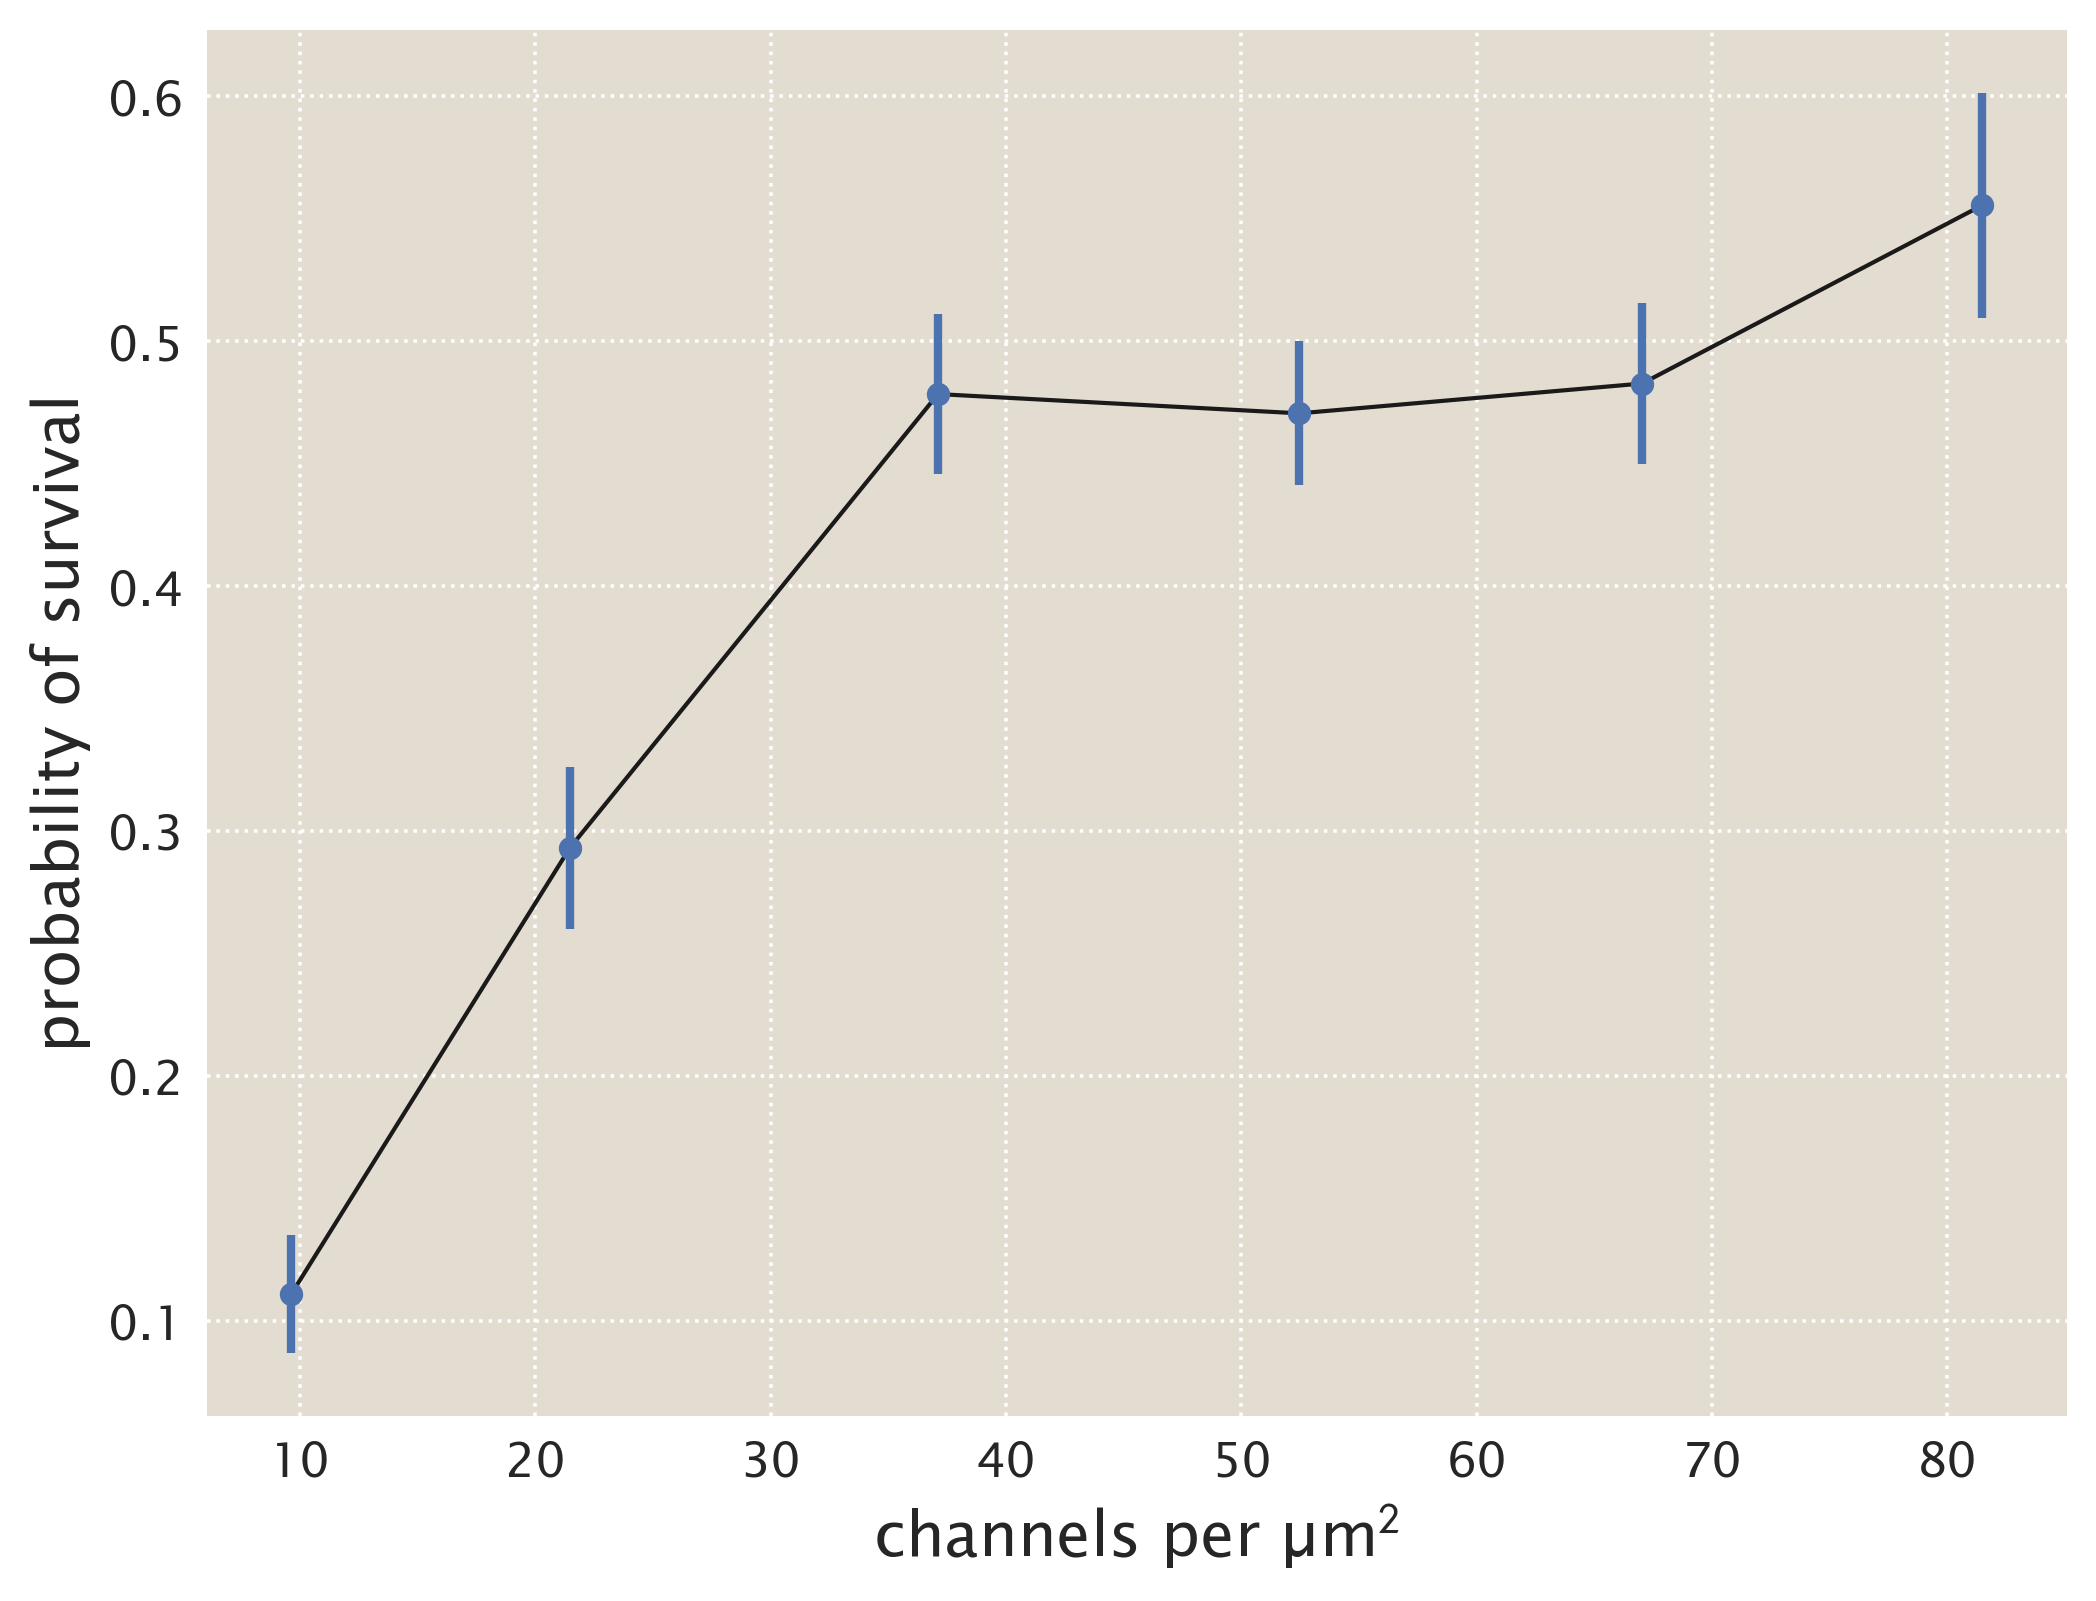

In [58]:
grouped = prob_df.groupby('flow_group')
i = 0
for g, d in grouped:
    if g=='fast':
        plt.plot(d['channel_density'], d['survival_probability'], 'k', linewidth=1, label='__nolegend__')
        plt.errorbar(d['channel_density'], d['survival_probability'], d['survivor_error'], fmt='o',
                    color=colors[i], linestyle='none', label=g)


#         plt.hlines(d['survival_probability'], d['min_int']* ip_dist**2, d['max_int'] * ip_dist**2,
#                    color=colors[i])
        i += 1
    
# plt.legend()
plt.ylabel('probability of survival', fontsize=15)
plt.xlabel('channels per µm$^2$', fontsize=15)
# plt.ylim([0, 1])
# leg = plt.legend(title='shock rate', fontsize=13, loc='lower right')
leg.get_title().set(fontsize=13)
plt.savefig('figs/fast_shock_survival_probability.pdf', bbox_inches='tight')

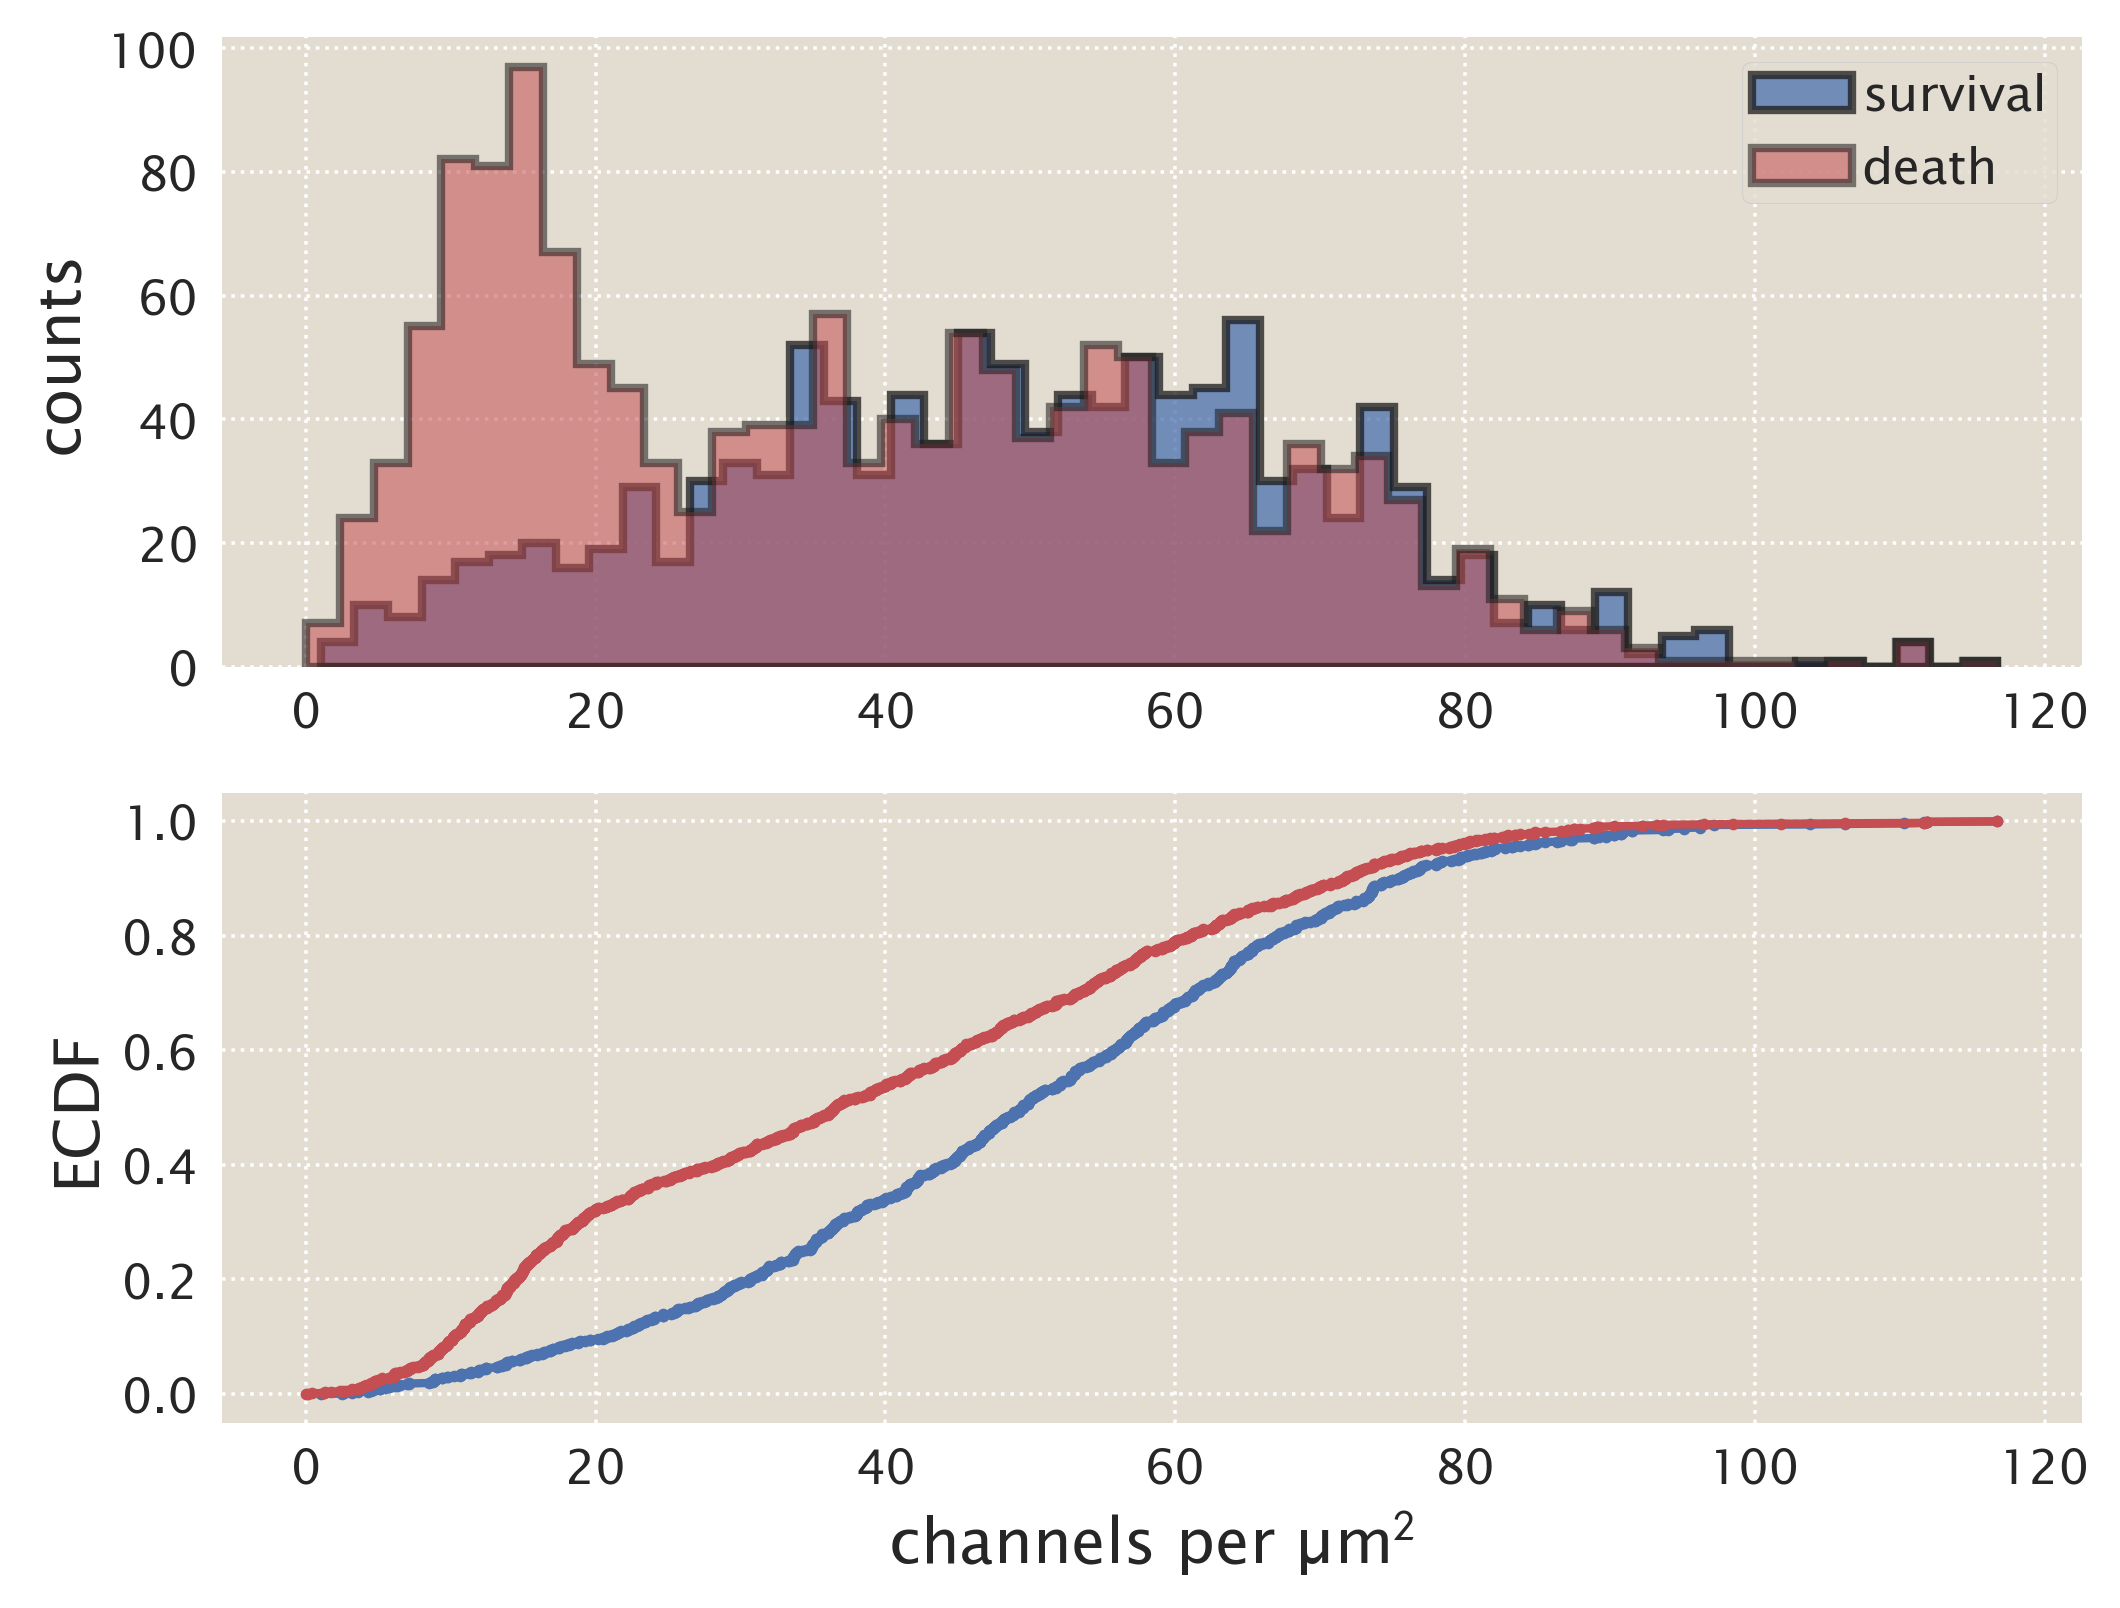

In [43]:
sns.set_palette('deep', color_codes=True)
alt_data = data[data['channel_density'] > 0]
fig, ax = plt.subplots(2,1)
_ = ax[0].hist(alt_data[alt_data['survival']==True]['channel_density'], color='b',
               histtype='stepfilled', bins=50, alpha=0.75, edgecolor='k',
              linewidth=2, label='survival')
_ = ax[0].hist(alt_data[alt_data['survival']==False]['channel_density'], color='r',
               histtype='stepfilled', bins=50, alpha=0.55, edgecolor='k',
              linewidth=2, label='death')
_ = ax[1].set_xlabel('channels per µm$^2$', fontsize=15)

def ecdf(data):
    return np.sort(data), np.arange(0, len(data)) / len(data)
x1, y1 = ecdf(alt_data[alt_data['survival']==True]['channel_density'])
x2, y2 = ecdf(alt_data[alt_data['survival']==False]['channel_density'])
_ = ax[1].plot(x1,y1,'.-', color='b')
_ = ax[1].plot(x2,y2,'.-', color='r')
_ = ax[0].set_ylabel('counts', fontsize=15)
_ = ax[1].set_ylabel('ECDF', fontsize=15)
leg_ = ax[0].legend(fontsize=12)
plt.savefig('figs/channel_distribution_survivability.pdf', bbox_inches='tight')

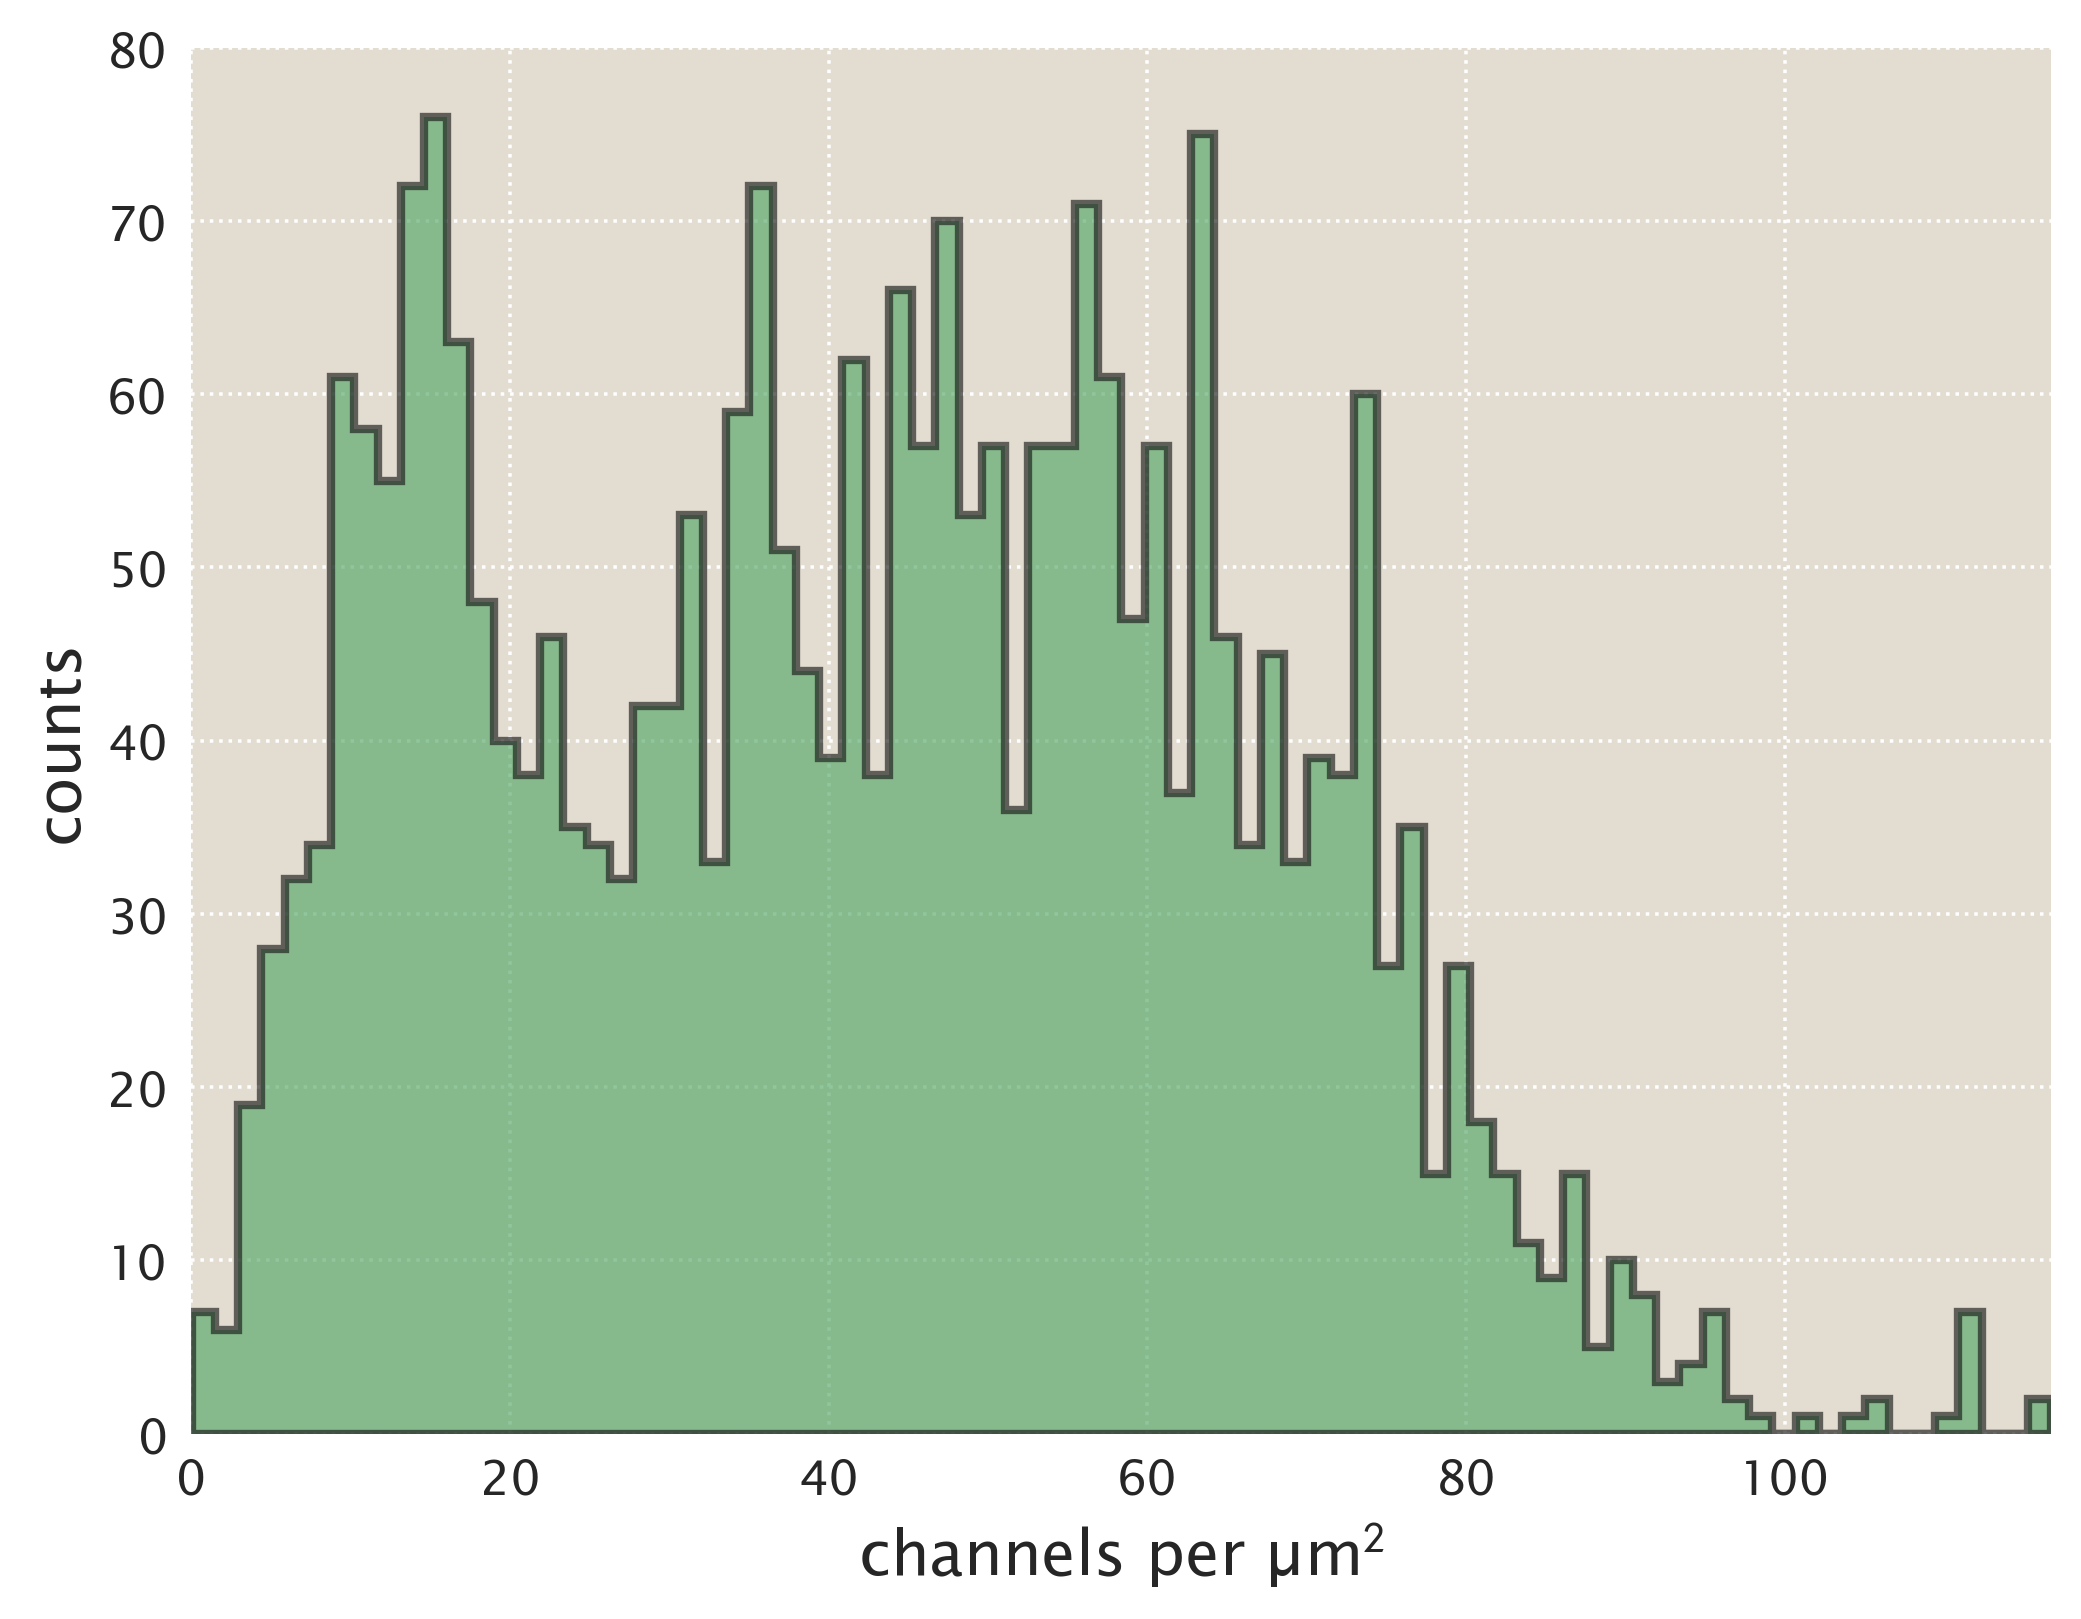

In [50]:
fig, ax = plt.subplots(1,1)
_ = ax.hist(alt_data['channel_density'], bins=80, color='g', alpha=0.65, histtype='stepfilled',
       edgecolor='k', linewidth=2)
ax.set_xlabel('channels per µm$^2$', fontsize=15)
ax.set_ylabel('counts', fontsize=15)

# slow_data = df[df['flow_group'] == 'slow']
y = np.linspace(0, 80, 1000)
# for b in range(1, len(bins) - 1):
#     if b%2 == 0:
#         alpha=0.2
#     else:
#         alpha=0.4
# #     ax.fill_betweenx(y, bins[b-1], bins[b], color='k', alpha=alpha)
    
ax.set_ylim((0, 80))
ax.set_xlim((0, data['channel_density'].max()))
# ax.fill_betweenx(y, bins[-2], data['channel_density'].max(), alpha=0.4, color='k')
plt.savefig('figs/full_channel_dist.pdf', bbox_inches='tight')

In [92]:
np.median(cal_data[cal_data['sd']=='MLG910']['area'])nali

4.6592000000000002

(array([  44.,   59.,   99.,  147.,  190.,  287.,  341.,  280.,  263.,
         229.,  178.,  165.,  153.,  123.,  126.,   68.,   81.,  105.,
          71.,   76.,   65.,   62.,   53.,   39.,   47.,   30.,   35.,
          14.,   21.,   17.,   16.,   20.,    8.,   20.,    8.,    3.,
           5.,   15.,    9.,    6.,   19.,   12.,   16.,    0.,    0.,
           9.,    7.,    3.,    0.,    0.,    2.,    0.,    3.,    6.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    5.]),
 array([  1.6384  ,   2.152704,   2.667008,   3.181312,   3.695616,
          4.20992 ,   4.724224,   5.238528,   5.752832,   6.267136,
          6.78144 ,   7.295744,   7.810048,   8.324352,   8.838656,
      

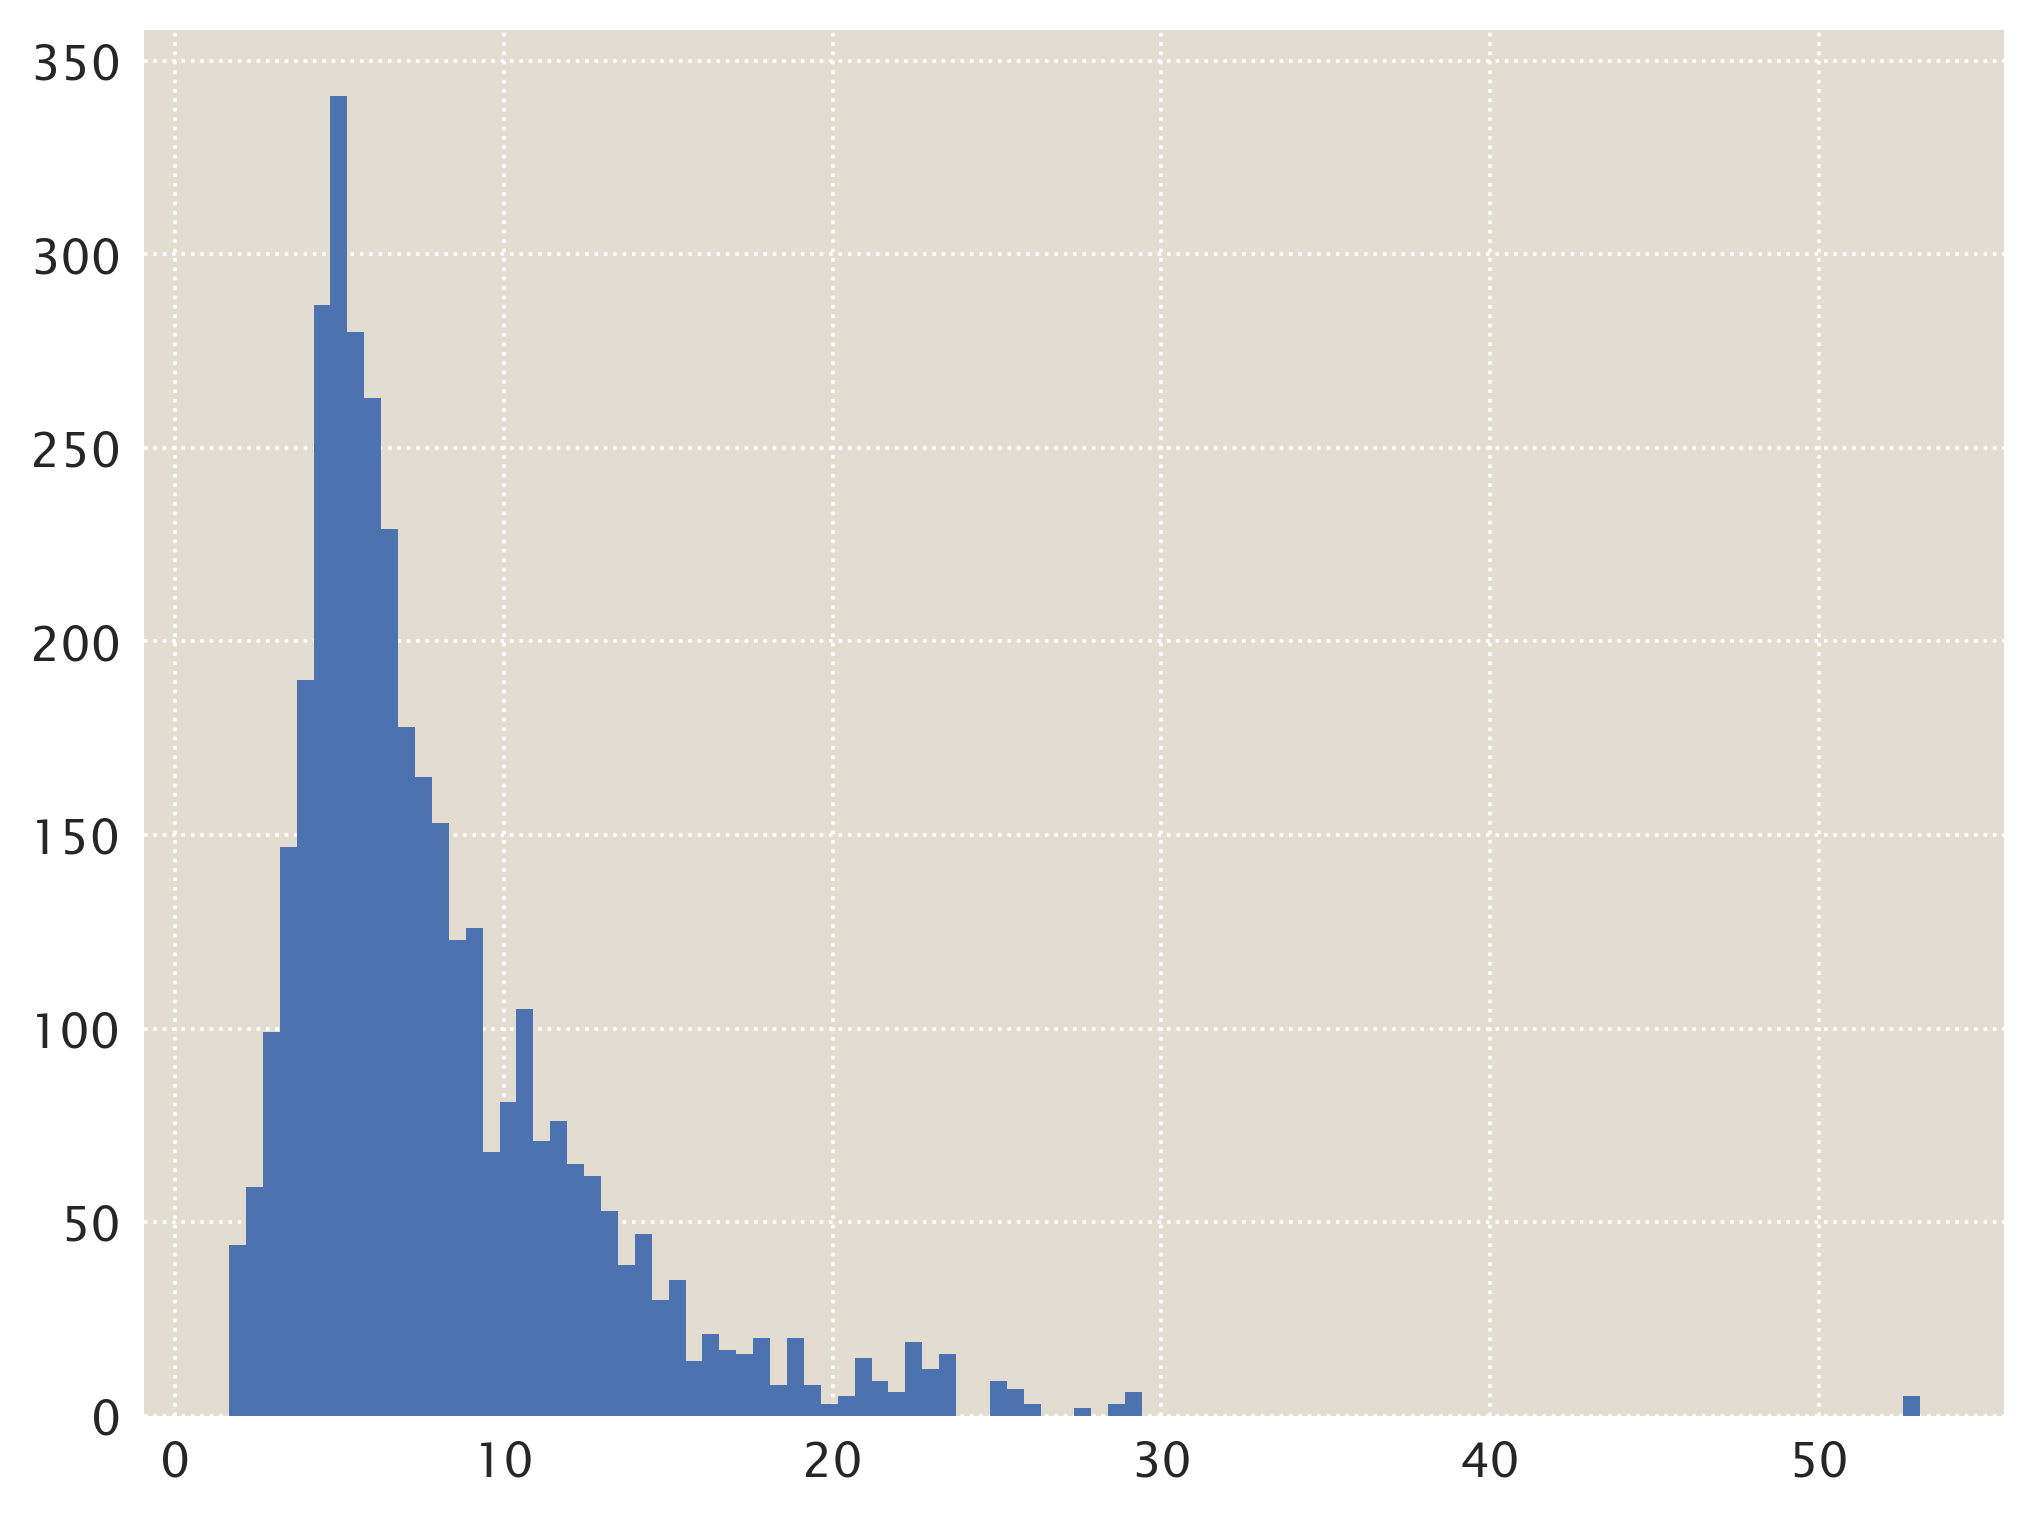

In [93]:
plt.hist(data['area'], bins=100)

In [94]:
np.median(data['area'])

6.5280000000000005

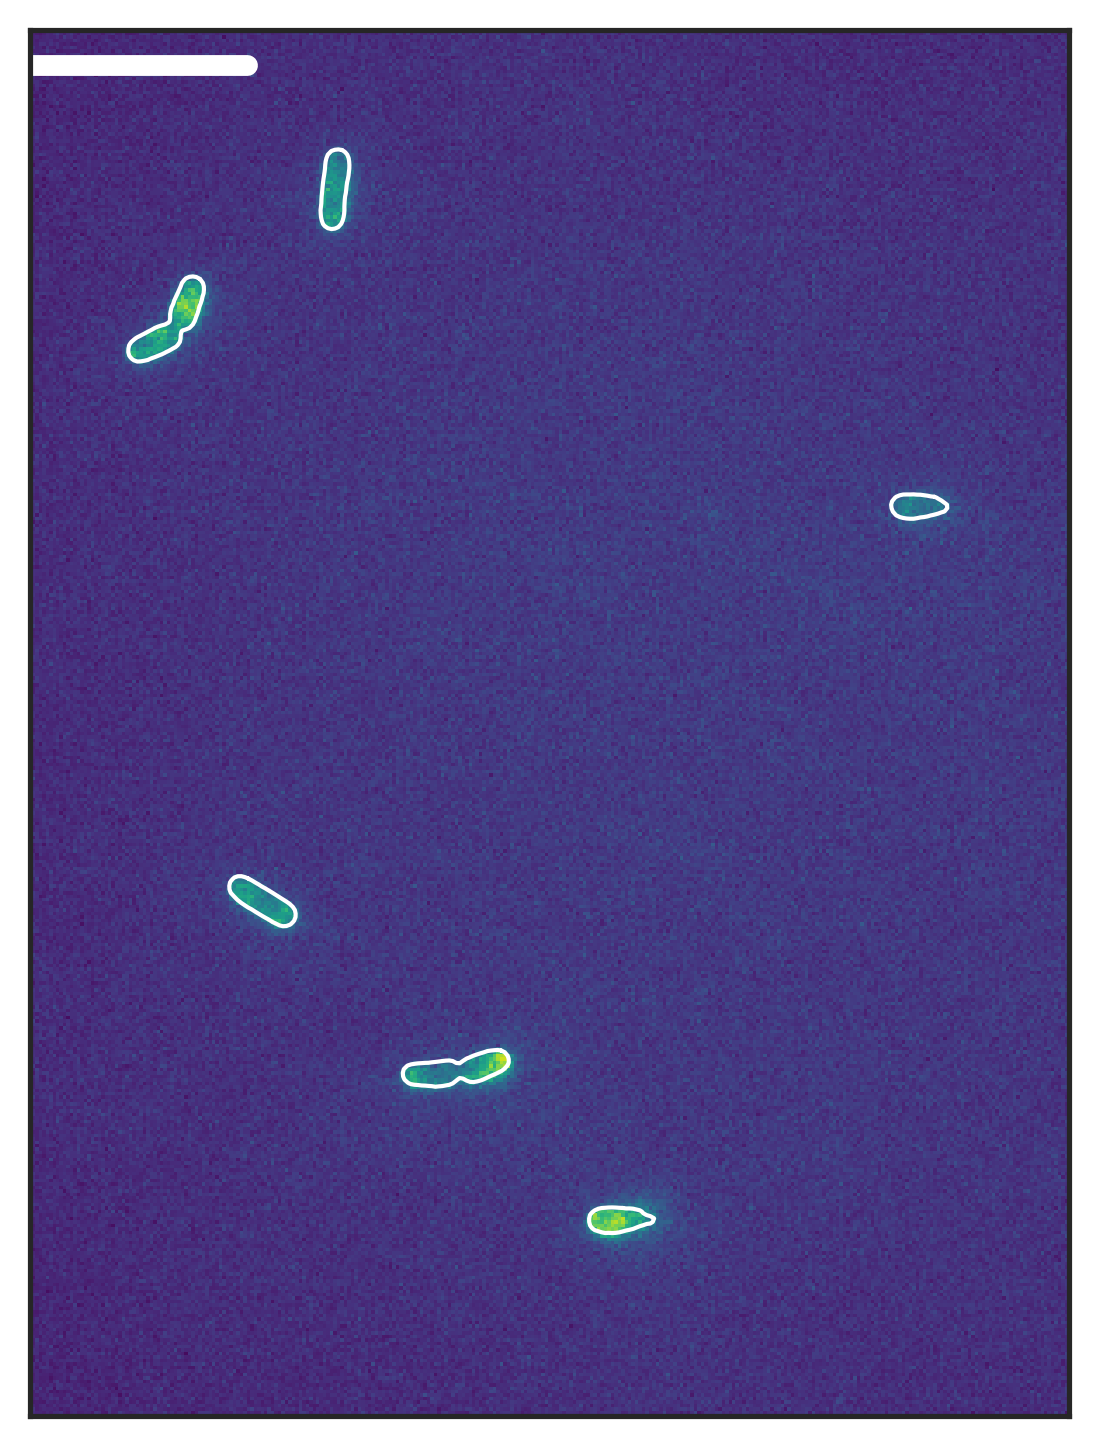

In [76]:
im = skimage.io.imread('data/images/intensity_calibration/MLG910/Jul21/MLG910_pre_50ms_1/Pos10/img_000000000_GFP_000.tif')
im_phase = skimage.io.imread('data/images/intensity_calibration/MLG910/Jul21/MLG910_pre_50ms_1/Pos10/img_000000000_Brightfield_000.tif')

conts, seg = mscl.contour_seg(im_phase, return_conts=True)

with sns.axes_style('white'):
    plt.imshow(im, cmap=plt.cm.viridis)
    for c in conts:
        if len(c) > 10:
            plt.plot(c[:,1], c[:,0], 'w-', lw=1)
    plt.plot(np.linspace(100, 100 + 10 / 0.160, 50), np.ones(50)*390, 'w-', lw=5)                
    plt.ylim((0, 400))
    plt.xlim((100, 400))
    plt.xticks([])
    plt.yticks([])
    plt.savefig('figs/gfp_seg_overlay.pdf', bbox_inches='tight')
